2021/07/03


#Vision Transformer による絵画の画材分類

参考：

* [google-research
/
vision_transformer](https://github.com/google-research/vision_transformer)
* [TensorFlow Core / tf.dataを使って画像をロードする](https://www.tensorflow.org/tutorials/load_data/images?hl=ja)

In [ ]:
import pandas as pd
import numpy as np
import numpy.random as random
from pandas import Series, DataFrame

In [ ]:
!git clone https://github.com/obrmmk/ViT_MET_datasets.git


train_data=pd.read_csv('./ViT_MET_datasets/painting/Medium/ten/painting_ten_train1.csv')
test_data=pd.read_csv('./ViT_MET_datasets/painting/Medium/ten/painting_ten_test1.csv')

Cloning into 'ViT_MET_datasets'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 56 (delta 19), reused 52 (delta 15), pack-reused 0
Unpacking objects: 100% (56/56), done.


In [ ]:
train_data.reset_index(inplace=True, drop=True)
train_data.head()
print(len(train_data))


1813


In [ ]:
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull
!pip install -qr vision_transformer/vit_jax/requirements.txt

Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 4), reused 18 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.
Already up to date.
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 184kB 44.8MB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
     |████████████████████████████████| 168.3MB 74kB/s 


In [ ]:
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [ ]:
model_name = 'ViT-L_16'  #@param ["ViT-B_16", "ViT-B_32","ViT-L_16","ViT-L_32","Mixer-B_16","R26+ViT-B_32","R50+ViT-B_16","R50+ViT-L_32"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-L_16.npz...
| [1 files][  1.2 GiB/  1.2 GiB]   45.0 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [ ]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

logging.set_verbosity(logging.INFO)
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

In [ ]:
import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [ ]:
import tensorflow as tf
from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE
label_names = sorted(list(set([item for item in train_data['Medium']])))
label_to_index_pre = dict((index,name) for index,name in enumerate(label_names))
df = pd.DataFrame.from_dict(label_to_index_pre, orient='index')
df = df.reset_index()
df = df.set_axis(['label', 'Medium'], axis=1)
all_image_labels=[]
for i in range(len(train_data)):
  all_image_labels.append(int(df[df['Medium'] == train_data.loc[i]['Medium']]['label']))
all_image_labels_i = [int(s) for s in all_image_labels]
n_labels = len(np.unique(all_image_labels_i))

count=0
def create_file(url):
  global count
  count+=1
  image = tf.keras.utils.get_file(str(count)+'.jpg', origin=url)
  return image

all_image_paths = list(train_data['primaryImage'])
memo = []
for i in range(len(train_data)):
  all_image_paths[i] = all_image_paths[i].replace(' ', '%20')
  if all_image_paths[i] == 'https://images.metmuseum.org/CRDImages/ad/original/DP-15885-001.jpg':
    memo.append(i)
all_image_paths.pop(*memo)



In [ ]:
!pip install tqdm
from tqdm.notebook import tqdm

for i in tqdm(all_image_paths):
  create_file(i)

1859584/1858306 [==============================] - 0s 0us/step



In [ ]:
import pathlib

data_root = pathlib.Path('/root/.keras/datasets/')
all_image_paths = sorted(list(sorted(data_root.glob('?.jpg'))))+sorted(list(sorted(data_root.glob('??.jpg'))))+sorted(list(sorted(data_root.glob('???.jpg'))))
all_image_paths = [str(path) for path in all_image_paths][4:]
all_image_labels_o = np.eye(n_labels)[all_image_labels_i] 

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3) #RGBなのでchannels=3
  image = tf.image.resize(image, [384, 384])
  image /= 255.0  #正規化（全てのデータを0～1の間の大きさにする） / 画像処理ではピクセルのRGB値(0~255)が特徴量となる
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_o, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

image_count = len(all_image_paths)

In [ ]:
n_labels

15

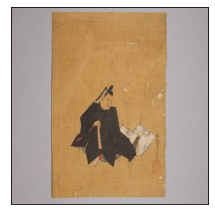

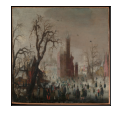

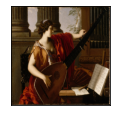

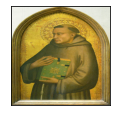

In [ ]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
 plt.subplot(2,2,n+1)
 plt.imshow(image)
 plt.grid(False)
 plt.xticks([])
 plt.yticks([])
 plt.show()

In [ ]:
image_count

995

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config     #スクショしてね

classifier: token
hidden_size: 1024
name: ViT-L_16
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 4096
  num_heads: 16
  num_layers: 24

In [ ]:
num_classes=15

In [ ]:
BATCH_SIZE = 5  
ds = image_label_ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE) 
batch = next(iter(ds.as_numpy_iterator()))

In [ ]:
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    batch[0][:1],
    train=False,
), backend='cpu')()

In [ ]:
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant
INFO:absl:load_pretrained: resized variant: (1, 197, 1024) to (1, 577, 1024)
INFO:absl:load_pretrained: grid-size from 14 to 24


In [ ]:
total_steps = 199
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 5 
base_lr = 0.03

In [ ]:
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [ ]:
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [ ]:
batch[0].shape[0]

5

  0%|          | 0/199 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
100%|██████████| 199/199 [08:43<00:00,  2.63s/it]


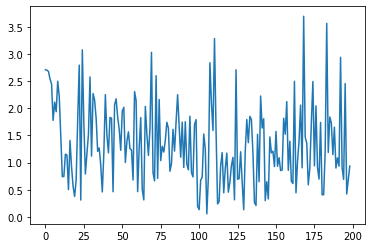

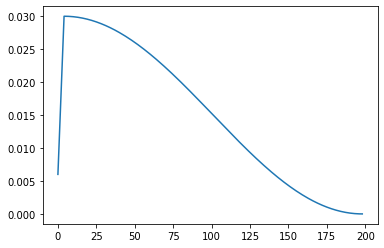

In [ ]:
import tqdm

losses = []
lrs = []
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds.as_numpy_iterator(),
):
  batch_dict = {
      'image':np.array([batch[0]]),
      'label':np.array([batch[1]])
  }

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch_dict, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

#テストデータのロード

In [ ]:
label_names_test = sorted(list(set([item for item in test_data['Medium']])))
label_to_index_pre_test = dict((index,name) for index,name in enumerate(label_names_test))
df_test = pd.DataFrame.from_dict(label_to_index_pre_test, orient='index')
df_test = df_test.reset_index()
df_test = df_test.set_axis(['label', 'Medium'], axis=1)
all_image_labels_test=[]
for i in range(len(test_data)):
  all_image_labels_test.append(int(df_test[df_test['Medium'] == test_data.loc[i]['Medium']]['label']))
all_image_labels_test_i = [int(s) for s in all_image_labels_test]
n_labels_test = len(np.unique(all_image_labels_test_i))

test_image_paths = list(test_data['primaryImage'])

memo = []
for i in range(778):
  test_image_paths[i] = test_image_paths[i].replace(' ', '%20')
  if test_image_paths[i] == 'https://images.metmuseum.org/CRDImages/ep/original/DT2628.jpg':
    memo.append(i)
  elif  test_image_paths[i] == 'https://images.metmuseum.org/CRDImages/ad/original/DP-19092-001.jpg':
    memo.append(i)
  elif test_image_paths[i] == 'https://images.metmuseum.org/CRDImages/ad/original/DP-19092-001.jpg':
    memo.append(i)

memo = sorted(memo, reverse=True)
for i in range(len(memo)):
  test_image_paths.pop(memo[i])


In [ ]:
from skimage import io
count=0
def create_file(url):
  global count
  count+=1
  io.imsave(os.getcwd()+'/test/'+str(count)+'.jpg', io.imread(url)) #実行前にtestというフォルダを作ってください
  return image

In [ ]:
from tqdm.notebook import tqdm
for i in tqdm(test_image_paths):
  create_file(i)

In [ ]:
data_root = pathlib.Path('/content/test')
test_image_paths = sorted(list(sorted(data_root.glob('?.jpg'))))+sorted(list(sorted(data_root.glob('??.jpg'))))+sorted(list(sorted(data_root.glob('???.jpg'))))
test_image_paths = [str(path) for path in test_image_paths][:-1]

path_ds_test = tf.data.Dataset.from_tensor_slices(test_image_paths)
image_ds_test = path_ds_test.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
image_count2 = len(test_image_paths)

In [ ]:
image_count2

775

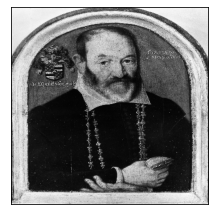

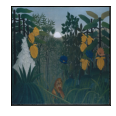

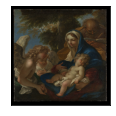

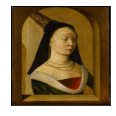

In [ ]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds_test.take(4)):
 plt.subplot(2,2,n+1)
 plt.imshow(image)
 plt.grid(False)
 plt.xticks([])
 plt.yticks([])
 plt.show()

In [ ]:
BATCH_SIZE = 5
ds_test = image_ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

#テストデータの画像分類

In [ ]:
import tqdm

In [ ]:
steps = image_count2 // BATCH_SIZE
for i, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()):
    if i == 0:
        predicted = vit_apply_repl(opt_repl.target, batch[np.newaxis, :])
        predicted = flax.nn.softmax(predicted)
        predict_prob = predicted[0]
    else:
        predicted = vit_apply_repl(opt_repl.target, batch[np.newaxis, :])
        predicted = flax.nn.softmax(predicted)
        predict_prob = np.append(predict_prob, predicted[0], axis=0)

In [ ]:
submit_file = pd.DataFrame(predict_prob)
submit_file.index = [path.replace("test/", "") for path in test_image_paths]
submit_file.to_csv("result_file.csv", header=False)

In [ ]:
submit_file.columns = label_names

In [ ]:
submit_file

,Ink and opaque watercolor on paper,"Ink, opaque watercolor, and gold on paper",Oil on canvas,"Oil on canvas, transferred from wood",Oil on copper,Oil on glass,Oil on linden,Oil on oak,Oil on oak panel,Oil on slate paper,Oil on wood,Tempera and gold on wood,Tempera on wood,"Tempera on wood, gold ground",Unmounted shikisi leaf; ink and color on silk
/content/1.jpg,0.008909,0.006332,0.715134,0.003026,0.010125,0.004422,0.002213,0.002805,0.002744,0.013686,0.153116,0.013520,0.005764,0.055691,0.002511
/content/2.jpg,0.011501,0.008786,0.630896,0.004408,0.011305,0.006724,0.003180,0.003839,0.003704,0.019215,0.199140,0.019545,0.009689,0.064541,0.003527
/content/3.jpg,0.009202,0.006952,0.657866,0.003385,0.009628,0.005310,0.002436,0.003008,0.002908,0.015916,0.199463,0.015772,0.007440,0.058002,0.002713
/content/4.jpg,0.008995,0.006701,0.654718,0.003413,0.009474,0.005260,0.002468,0.003030,0.002950,0.015429,0.206711,0.015328,0.007312,0.055507,0.002705
/content/5.jpg,0.008435,0.006412,0.695326,0.002991,0.009913,0.004717,0.002249,0.002906,0.002793,0.014058,0.173462,0.013466,0.005735,0.054980,0.002556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/content/771.jpg,0.009723,0.007212,0.666507,0.003435,0.010049,0.005283,0.002509,0.003066,0.002976,0.015547,0.183759,0.016133,0.007355,0.063572,0.002876
/content/772.jpg,0.009829,0.007574,0.640452,0.003844,0.010705,0.005839,0.002754,0.003388,0.003256,0.017513,0.212376,0.017112,0.008312,0.054069,0.002978
/content/773.jpg,0.007272,0.005250,0.734317,0.002457,0.009284,0.003891,0.001921,0.002508,0.002351,0.010543,0.147539,0.010258,0.004489,0.055802,0.002116
/content/774.jpg,0.010585,0.007977,0.642218,0.003977,0.011073,0.006056,0.002848,0.003473,0.003364,0.017959,0.199475,0.017857,0.008660,0.061437,0.003041


In [ ]:
results = pd.DataFrame(results)
results.index = [path.replace("test/", "") for path in test_image_paths]
results.to_csv("results.csv", header=False)

In [ ]:
c=0
for i in range(image_count2):
  if results.iloc[i][0] == test_data['Medium'][i]:
    c+=1

In [ ]:
print(c)

520


In [ ]:
accuracy = c / image_count2
accuracy

0.6709677419354839